## Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
ls

drive/  sample_data/


In [3]:
cd 'drive/My Drive/FER'

/content/drive/My Drive/FER


In [4]:
# For displaying the graphs in the cell itself.
%matplotlib inline

# This is for setting the figure size
from pylab import rcParams
rcParams['figure.figsize'] = 4, 4

import keras
from keras.models import load_model

# skimage for image operations
from skimage import data, img_as_float
from skimage import exposure
from skimage import io
import cv2
# os for read write operations
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from skimage.transform import rescale
# For reading images from disk
import matplotlib.image as mpimg
from matplotlib import cm

# Used for class weights but ignore this for now
from sklearn.utils import class_weight
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


## Load the data from the csv file

Here, we dropped 'Usage' because it is not needed

In [0]:
data = pd.read_csv("fer2013.csv")
data.drop(['Usage'], axis = 1, inplace = True)

In [16]:
data.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


## To check if there are any null values in the data or not

In [17]:
data.isnull().sum()

emotion    0
pixels     0
dtype: int64

## Just defining the classes and the image size

In [0]:
nb_classes = 7
image_width = 48
image_height = 48
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

## This countplot check how many images we have for each emotion

([<matplotlib.axis.XTick at 0x7f3427dfa358>,
 <a list of 7 Text xticklabel objects>)

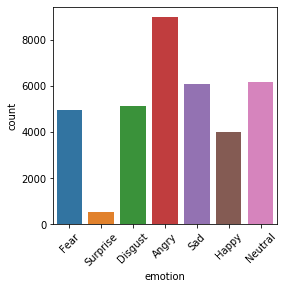

In [19]:
import seaborn as sns

sns.countplot(x='emotion', data= data)
plt.xticks(np.arange(7), set(emotion_labels), rotation=45)

In [0]:
X = data.pixels
y = data.emotion

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.005)

In [0]:
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size = 0.03)

In [0]:
Y_train

30929    5
18129    6
3452     3
13891    6
15456    5
        ..
18898    3
29507    0
12892    3
32836    4
3823     4
Name: emotion, Length: 34635, dtype: int64

In [0]:
# Create three folders "Test_data", "Train_data", and "Validation_data"
# Inside these folders create  folders each named after the  classes that we have.

In [0]:
count = 0
for image, label in zip(X_train, Y_train):

    # This line splits the pixel string to a list of numbers(pixels)
    sample_img = np.array([int(s) for s in image.split(' ')])
    
    # Reshapes each image to (48, 48) instead of (48, 48, 1)
    sample_img = sample_img.reshape(48, 48)
    # Write each image to the disk with a suitable name
    cv2.imwrite(f'Train_data/{emotion_labels[label]}/image_{count}.jpg', sample_img)
    count += 1

In [0]:
count = 0
for image, label in zip(X_test, Y_test):

    # This line splits the pixel string to a list of numbers(pixels)
    sample_img = np.array([int(s) for s in image.split(' ')])
    
    # Reshapes each image to (48, 48) instead of (48, 48, 1)
    sample_img = sample_img.reshape(48, 48)
    # Write each image to the disk with a suitable name
    cv2.imwrite(f'Test_data/{emotion_labels[label]}/image_{count}.jpg', sample_img)
    count += 1

In [0]:
count = 0
for image, label in zip(X_validation, Y_validation):

    # This line splits the pixel string to a list of numbers(pixels)
    sample_img = np.array([int(s) for s in image.split(' ')])
    
    # Reshapes each image to (48, 48) instead of (48, 48, 1)
    sample_img = sample_img.reshape(48, 48)
    # Write each image to the disk with a suitable name
    cv2.imwrite(f'Validation_data/{emotion_labels[label]}/image_{count}.jpg', sample_img)
    count += 1

## This is used to read all images from the csv and keep them in memory

- This was done just for testing purposes, do not run the next two cells and let the output be as it is

In [0]:
import matplotlib.cm as cm
import warnings

warnings.filterwarnings("ignore")

X = list()
Y = list()

# This is used to scale the pixel values for each image
# E.g. now, each pixel value will be between 0 and 1 instead of being between 0 and 255
def scale(img):
    img = (img - img.min())/(img.max() - img.min())
    return img

for image, label in zip(data.pixels, data.emotion):
    sample_img = np.array([int(s) for s in image.split(' ')])
    sample_img = sample_img.reshape(image_height, image_width)
    X.append(scale(sample_img))
    Y.append(label)

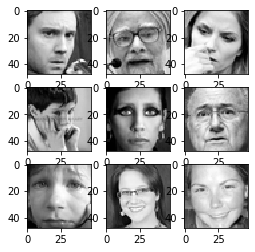

In [0]:
# Just to display some random images in the dataset

for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X[i], cmap = cm.gray)

# plt.imshow(X[0], cmap = cm.gray)

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=False,
    featurewise_std_normalization=False,
#     rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
#     vertical_flip=True,
    horizontal_flip= True,
    # brightness_range=[0.9, 1.1],
    zoom_range=0.1)
#     shear_range= 0.2)

train_generator = train_datagen.flow_from_directory(
    directory=r"./Train_data/",
    target_size=(48, 48),
    color_mode="grayscale",
    batch_size=64,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 34635 images belonging to 7 classes.


In [0]:
from keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(
    rescale=1./255
)

validation_generator = test_datagen.flow_from_directory(
    directory=r"./Validation_data/",
    target_size=(48, 48),
    color_mode="grayscale",
    batch_size=64,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 1072 images belonging to 7 classes.


## Class Weights For tackling Class Imbalance

 - Currently Not being Used hence ignore

In [0]:
Y_train = np.array(Y)

unique= np.unique(Y_train)

weights = class_weight.compute_class_weight('balanced', unique, Y_train)
class_weights= dict()

for (key, value) in enumerate(weights):
    class_weights[key]= value

print(class_weights)

NameError: ignored

## Splitting the images into train and test

Again this was done for testing purposes. This is handled inside the Keras Sequence class itself.


Do Not run the next 3 cells

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(np.array(X), np.array(Y), test_size=0.1, random_state=42)

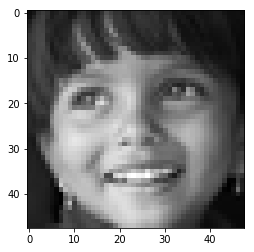

In [0]:
img = X_train[0].reshape(48, 48)

stacked_img = np.stack((img,)*3, axis=-1)

plt.imshow(stacked_img)

In [0]:
gray = X_train[0]

img2 = X_train[0]

img2[:,:,0] = gray
img2[:,:,1] = gray
img2[:,:,2] = gray

## This is the Keras Image Data Genarator class

Kindly read up on this from the keras documentation https://keras.io/preprocessing/image/

## This small script was used to test the different parameters of datagen

Again, do not run this

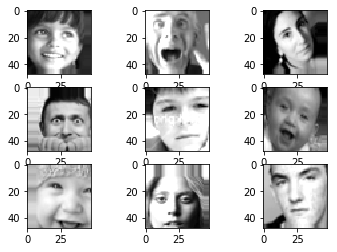

In [0]:
X_train= X_train.reshape(-1, 48, 48, 1)
X_test= X_test.reshape(-1, 48, 48, 1)
Y_train= Y_train.reshape(-1, 1)
Y_test= Y_test.reshape(-1, 1)
X_train= X_train.astype('float32')
X_test= X_test.astype('float32')

datagen.fit(X_train)
for X_batch, Y_batch in datagen.flow(X_train, Y_train, batch_size= 10, shuffle= False):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(48, 48), cmap=plt.get_cmap('gray'))

    break

## This was used to calculate the one hot encoded vectors

DO not run this

In [0]:
classes, array= np.unique(Y_train, return_inverse= True)
Y_train_ohe= keras.utils.to_categorical(array, len(classes))

classes, array= np.unique(Y_test, return_inverse= True)
Y_test_ohe= keras.utils.to_categorical(array, len(classes))

## This is used to preprocess the image

In [0]:
img_rows= 48
img_cols= 48

def scale(img):
    img= (img - img.min())/(img.max() - img.min())
    return img

def preprocess_img(img, mode):
    
    img= cv2.resize(img, (img_rows, img_cols))
    img = scale(img)
    
#     img = np.stack((img,)*3, axis=-1)
    
    img = img.reshape(48, 48, 1)
    
    if mode == 'train':
        if np.random.randn() > 0:
            img = datagen.random_transform(img)
    
    return img

Run everything from here on

In [0]:
img_channels = 1
img_rows = 48
img_cols = 48

nb_classes = len(emotion_labels)

In [0]:
import numpy as np
import keras
DATASET_PATH = "data/"

class AugmentedDataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, mode='train', ablation=None, emotion_cls = emotion_labels, 
                 batch_size = 64, dim = (48, 48), n_channels = 1, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = {}
        self.list_IDs = []
        self.mode = mode
        
        for i, cls in enumerate(emotion_cls):
            paths = glob.glob(os.path.join(DATASET_PATH, cls, '*'))
            brk_point = int(len(paths)*0.93)
            if self.mode == 'train':
                paths = paths[:brk_point]
            else:
                paths = paths[brk_point:]
            if ablation is not None:
                paths = paths[:int(len(paths)*ablation/100)]
            self.list_IDs += paths
            self.labels.update({p:i for p in paths})
        
            
        self.n_channels = n_channels
        self.n_classes = len(emotion_cls)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'

        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
#             img = io.imread(ID)
            img = mpimg.imread(ID)
            img = img[:, :, np.newaxis]
            

            img = img.reshape(48, 48, 1)
            X[i,] = img
            y[i] = self.labels[ID]
        
        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [0]:
training_generator = AugmentedDataGenerator('train')
validation_generator = AugmentedDataGenerator('val')


# Callbacks

Callbacks are used to monitor and manipulate the training procedure.

In [0]:
from keras.callbacks import Callback

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency.
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    The amplitude of the cycle can be scaled on a per-iteration or
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each
        cycle iteration.
    For more detail, please see paper.
    # Example for CIFAR-10 w/ batch size 100:
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    # References
      - [Cyclical Learning Rates for Training Neural Networks](
      https://arxiv.org/abs/1506.01186)
    """

    def __init__(
            self,
            base_lr=0.001,
            max_lr=0.006,
            step_size=2000.,
            mode='triangular',
            gamma=1.,
            scale_fn=None,
            scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        if mode not in ['triangular', 'triangular2',
                        'exp_range']:
            raise KeyError("mode must be one of 'triangular', "
                           "'triangular2', or 'exp_range'")
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn is None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1 / (2.**(x - 1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma ** x
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr is not None:
            self.base_lr = new_base_lr
        if new_max_lr is not None:
            self.max_lr = new_max_lr
        if new_step_size is not None:
            self.step_size = new_step_size
        self.clr_iterations = 0.

    def clr(self):
        cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr - self.base_lr) * \
                np.maximum(0, (1 - x)) * self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr - self.base_lr) * \
                np.maximum(0, (1 - x)) * self.scale_fn(self.clr_iterations)

    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())

    def on_batch_end(self, epoch, logs=None):

        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1
        K.set_value(self.model.optimizer.lr, self.clr())

        self.history.setdefault(
            'lr', []).append(
            K.get_value(
                self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

### Tensorboard Callback

Run this in terminal: <br/>
tensorboard --logdir path_to_current_dir/logs 

In [0]:
from sklearn.metrics import roc_auc_score
from keras import optimizers

# This manipulates the leanring rate
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import *
# from CLR_master.clr_callback import *
import warnings

warnings.filterwarnings("ignore")

# This callback is used to calculate the AUC-ROC score after each epoch.
# We consider the auc 'roc-score' instead of 'accuracy' because the dataset has 'class imbalance'
class roc_callback(Callback):

    def on_train_begin(self, logs={}):
        logs['val_auc'] = 0

    def on_epoch_end(self, epoch, logs={}):
        y_p = []
        y_v = []
        for i in range(len(validation_generator)):
            x_val, y_val = validation_generator[i]
            y_pred = self.model.predict(x_val)
            y_p.append(y_pred)
            y_v.append(y_val)
        y_p = np.concatenate(y_p)
        y_v = np.concatenate(y_v)
        roc_auc = roc_auc_score(y_v, y_p)
        print ('\nVal AUC for epoch{}: {}'.format(epoch, roc_auc))
        logs['val_auc'] = roc_auc        

auc_logger = roc_callback()
BATCH_SIZE = 32

lr_reduce = ReduceLROnPlateau(monitor='acc', factor = 0.1, epsilon = 0.0001, patience = 1, verbose = 0)

# This callback is used to change the learning rate during the training itself.
# You can check the graph that is plotted down in the notebook to understand it.
# You can also read up on the same here: https://github.com/bckenstler/CLR
clr_triangular2 = CyclicLR(mode = 'triangular2', base_lr = 0.001, max_lr = 0.000005, step_size = 1500)
clr_triangular = CyclicLR(mode = 'triangular', base_lr = 0.001, max_lr = 0.000005, step_size = 1500)

# This is the tensorboard callback. It plots the trend of loss, accuracy, auc scores for analysis
# These graphs can be accessed by running "tensorboard --logdir path_to_current_dir/logs" in another terminal
tb_callback= keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size = BATCH_SIZE, write_graph=False)

## Model Checkpoint

- This is used to save the best model during the training phase instead of the last model.
- It keeps a track of te minimum validation auc score and saves that model at that training stage

In [0]:
filepath = 'models/best_model.hdf5'

checkpoint= keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=0, 
                                save_best_only=True, mode='max', period=1)

## Importing the different layers that we want from keras

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dropout, Dense, MaxPool2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

import keras.backend as K

In [0]:
def swish_activation(x):
    return (K.sigmoid(x) * x)

In [0]:
BATCH_SIZE = 64
EPOCHS = 15

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(48,48,1)))
model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation = swish_activation))
model.add(Dropout(0.4))
model.add(Dense(7 , activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam' ,
              metrics=['accuracy'])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [0]:
from keras.utils.vis_utils import plot_model

plot_model(model,to_file="model.jpg", show_shapes= True, show_layer_names= True)

In [0]:
class_weights = {0: 1.035072539009547, 1: 9.372420997649517, 2: 1.001115853488437, 3: 0.5703319930708962, 4: 0.8436258492207152, 5: 1.2810380524023703, 6: 0.8271562255105334}

history = model.fit_generator(generator = train_generator,
                    validation_data=validation_generator,
                    epochs = EPOCHS, callbacks = [clr_triangular2, checkpoint])
#                               , class_weight = class_weights)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








Epoch 1/15
542/542 [==============================] - 600s 1s/step - loss: 1.8280 - acc: 0.2405 - val_loss: 1.8444 - val_acc: 0.2696
Epoch 2/15
542/542 [==============================] - 602s 1s/step - loss: 1.8022 - acc: 0.2502 - val_loss: 1.7679 - val_acc: 0.2854
Epoch 3/15
542/542 [==============================] - 602s 1s/step - loss: 1.7708 - acc: 0.2595 - val_loss: 1.7401 - val_acc: 0.3032
Epoch 4/15
542/542 [==============================] - 598s 1s/step - loss: 1.6994 - acc: 0.3128 - val_loss: 1.5676 - val_acc: 0.4039
Epoch 5/15
151/542 [=======>......................] - ETA: 7:14 - loss: 1.5658 - acc: 0.3889

KeyboardInterrupt: ignored

## Graph of the movement of learning rate during the training  

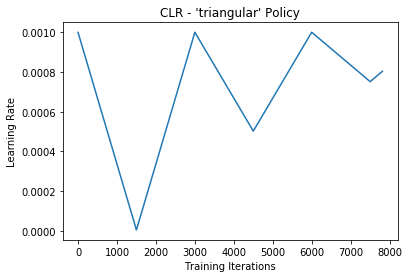

In [0]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular 2' Policy")
plt.plot(clr_triangular2.history['iterations'], clr_triangular2.history['lr'])

In [14]:
model = load_model("models/saved_best_model.hdf5", custom_objects={"swish_activation":swish_activation})



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [15]:
emotion_labels

['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [16]:
TEST_DATASET_PATH = "Test_data"

final_paths = list()
final_y = list()
for i, cls in enumerate(emotion_labels):
    paths = glob.glob(os.path.join(TEST_DATASET_PATH, cls, '*'))
    label = [emotion_labels.index(cls)] * len(paths)
    final_y += label
    final_paths += paths

22
Angry
11
Disgust
37
Fear
47
Happy
23
Sad
16
Surprise
35
Neutral


In [0]:
X = list()
y = list()

for path, label in zip(final_paths, final_y):

    img = mpimg.imread(path)
    # img = img[:, :, np.newaxis]

    # img = img.reshape(48, 48, 1)
    X.append(img)
    y.append(label)

In [0]:
X = np.array(X)
X = X.reshape(-1, 48, 48, 1)
y = np.array(y)

In [0]:
y_predicted = model.predict_classes(X)
y_pred = model.predict_proba(X)
classes, array= np.unique(y, return_inverse= True)
y_true= keras.utils.to_categorical(array, len(classes))

0.9152194651474928


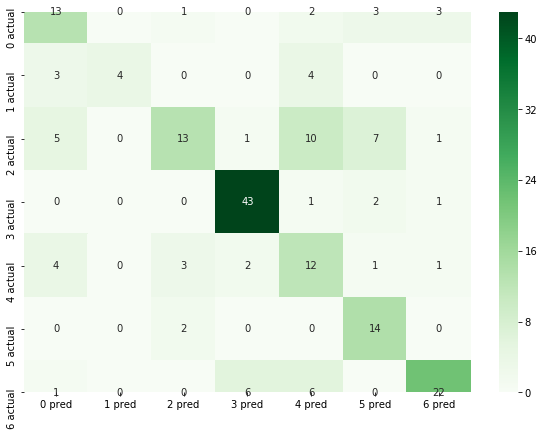

In [47]:


# Just make the changes according to emotions project
logit_roc_auc = roc_auc_score(y_true, y_pred)
# fpr, tpr, thresholds = roc_curve(y_true, y_pred)
# plt.figure()
# plt.plot(fpr, tpr, label='Logistic Regression (area = %0.4f)' % logit_roc_auc)
# plt.plot([0, 1, 2, 3, 4, 5, 6], [0, 1, 2, 3, 4, 5, 6],'r--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC')
# plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
# plt.show()

print("AUC ROC Score:", logit_roc_auc)

import seaborn as sns
cm = confusion_matrix(y, y_predicted)
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g', cmap= 'Greens', xticklabels=['0 pred', '1 pred', '2 pred', '3 pred', '4 pred', '5 pred', '6 pred'], 
            yticklabels=['0 actual', '1 actual', '2 actual', '3 actual', '4 actual', '5 actual', '6 actual'])